In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten, GlobalAveragePooling2D,AveragePooling2D
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, Add, Activation
from tqdm import tqdm
### OG Paper: Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network
### Dataset: https://press.liacs.nl/mirflickr/mirdownload.html

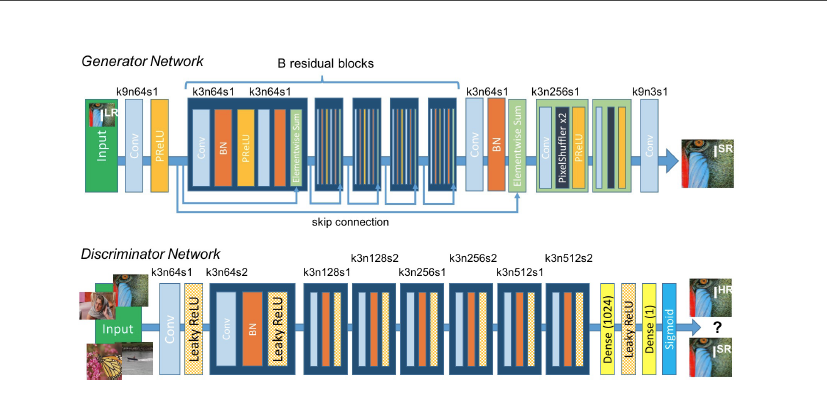

In [2]:
def residual_block(inputs):
    x= Conv2D(64, kernel_size=3, padding="same", strides=1, use_bias=False)(inputs)
    x= BatchNormalization()(x)
    x= PReLU(shared_axes=[1,2])(x)
    x= Conv2D(64, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x= BatchNormalization()(x)
    x= Add()([inputs, x])
    return x  

In [5]:
def upsample_block(inputs, scale_factor=2):
    x= Conv2D(256, kernel_size=3, padding="same", strides=1)(inputs)
    print(x.shape)
    x= tf.nn.depth_to_space(x, 2, data_format="NHWC")###tesnorflow version of pytorch's PixelShuffler layer
    print(x.shape)
    x= PReLU(shared_axes=[1,2])(x)
    return x 

In [6]:
def build_generator():
    lr_shape= Input(shape=(64,64,3))
    x= Conv2D(64, (9,9), padding="same")(lr_shape)
    x= PReLU(shared_axes=[1,2])(x)
    
    y=x
    
    for i in range(16):
        x= residual_block(x)
    print(x.shape)
    x= Conv2D(64, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x= BatchNormalization()(x)
    print(x.shape)
    x= Add()([x, y])
    print(x.shape)
    x= upsample_block(x)
    x= upsample_block(x)
    x= Conv2D(3, (9,9), padding="same")(x)
    out= Activation("tanh")(x) ###in the paper it is not specified if they use tanh but hr images are scaled to -1,1 so we use a tanh activation
    print(out.shape)
    return Model(inputs=lr_shape, outputs=out)

In [7]:
generator = build_generator()
generator.summary()

(None, 64, 64, 64)
(None, 64, 64, 64)
(None, 64, 64, 64)
(None, 64, 64, 256)
(None, 128, 128, 64)
(None, 128, 128, 256)
(None, 256, 256, 64)
(None, 256, 256, 3)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 64, 64, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              

 add_4 (Add)                    (None, 64, 64, 64)   0           ['add_3[0][0]',                  
                                                                  'batch_normalization_9[0][0]']  
                                                                                                  
 conv2d_11 (Conv2D)             (None, 64, 64, 64)   36864       ['add_4[0][0]']                  
                                                                                                  
 batch_normalization_10 (BatchN  (None, 64, 64, 64)  256         ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 p_re_lu_6 (PReLU)              (None, 64, 64, 64)   64          ['batch_normalization_10[0][0]'] 
                                                                                                  
 conv2d_12

 p_re_lu_11 (PReLU)             (None, 64, 64, 64)   64          ['batch_normalization_20[0][0]'] 
                                                                                                  
 conv2d_22 (Conv2D)             (None, 64, 64, 64)   36864       ['p_re_lu_11[0][0]']             
                                                                                                  
 batch_normalization_21 (BatchN  (None, 64, 64, 64)  256         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_10 (Add)                   (None, 64, 64, 64)   0           ['add_9[0][0]',                  
                                                                  'batch_normalization_21[0][0]'] 
                                                                                                  
 conv2d_23

                                                                  'batch_normalization_31[0][0]'] 
                                                                                                  
 conv2d_33 (Conv2D)             (None, 64, 64, 64)   36864       ['add_15[0][0]']                 
                                                                                                  
 batch_normalization_32 (BatchN  (None, 64, 64, 64)  256         ['conv2d_33[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_16 (Add)                   (None, 64, 64, 64)   0           ['batch_normalization_32[0][0]', 
                                                                  'p_re_lu[0][0]']                
                                                                                                  
 conv2d_34

In [8]:
def disc_block(inputs, filters, strides=1):
    
    x = Conv2D(filters, (3,3), strides = strides, padding="same", use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x= LeakyReLU(0.2)(x)
    return x

In [9]:
def build_discriminator():
    hr_shape= Input(shape=(256,256,3))
    x= Conv2D(64, (3,3), padding="same")(hr_shape)
    x= LeakyReLU(0.2)(x)
    print(x.shape)
    x=disc_block(x, 64, strides=2)
    print(x.shape)
    x=disc_block(x, 128)
    print(x.shape)
    x=disc_block(x, 128, strides=2)
    print(x.shape)
    x=disc_block(x, 256)
    print(x.shape)
    x=disc_block(x, 256, strides=2)
    print(x.shape)
    x=disc_block(x, 512)
    print(x.shape)
    x=disc_block(x, 512, strides=2)
    print(x.shape)
    x = Flatten()(x)
    x = Dense(1024)(x)
    x = LeakyReLU(0.2)(x)
    out = Dense(1, activation='sigmoid')(x)

    
    
    return Model(inputs=hr_shape, outputs=out)

In [10]:
discriminator = build_discriminator()
discriminator.summary()

(None, 256, 256, 64)
(None, 128, 128, 64)
(None, 128, 128, 128)
(None, 64, 64, 128)
(None, 64, 64, 256)
(None, 32, 32, 256)
(None, 32, 32, 512)
(None, 16, 16, 512)
(None, 16, 16, 512)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_37 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 64)      0         
                                                                 
 conv2d_38 (Conv2D)          (None, 128, 128, 64)      36864     
                                                                 
 batch_normalization_33 (Bat  (None, 128, 128, 64)     256       
 chNormalization)                                                
       

In [11]:
# Define loss function
BCE = tf.keras.losses.BinaryCrossentropy(from_logits=False)


In [12]:
# Define VGG19 model and feature extractor outside the train_step function
vgg_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg_feature_extractor = tf.keras.Model(inputs=vgg_model.input, outputs=vgg_model.get_layer('block5_conv4').output)

In [13]:
def content_loss(generated_sr, hr_image, vgg_feature_extractor):
    preprocessed_hr_image = tf.keras.applications.vgg19.preprocess_input(hr_image)
    preprocessed_generated_sr = tf.keras.applications.vgg19.preprocess_input(generated_sr)
    hr_features = vgg_feature_extractor(preprocessed_hr_image)
    generated_sr_features = vgg_feature_extractor(preprocessed_generated_sr)
    return tf.keras.losses.MeanSquaredError()(hr_features, generated_sr_features)

In [14]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = BCE(tf.ones_like(disc_real_output), disc_real_output)
    fake_loss = BCE(tf.zeros_like(disc_generated_output), disc_generated_output)
    return real_loss + fake_loss

In [15]:
def generator_loss(disc_generated_output, generated_images, target, vgg_feature_extractor):
    adversarial_loss = 1e-3 * BCE(tf.ones_like(disc_generated_output), disc_generated_output)
    vgg_loss = 0.006 * content_loss(generated_images, target, vgg_feature_extractor)
    total_gen_loss = adversarial_loss + vgg_loss
    return total_gen_loss

In [16]:
# Instantiate generator and discriminator
generator = build_generator()
discriminator = build_discriminator()

(None, 64, 64, 64)
(None, 64, 64, 64)
(None, 64, 64, 64)
(None, 64, 64, 256)
(None, 128, 128, 64)
(None, 128, 128, 256)
(None, 256, 256, 64)
(None, 256, 256, 3)
(None, 256, 256, 64)
(None, 128, 128, 64)
(None, 128, 128, 128)
(None, 64, 64, 128)
(None, 64, 64, 256)
(None, 32, 32, 256)
(None, 32, 32, 512)
(None, 16, 16, 512)
(None, 16, 16, 512)


In [17]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9)

In [18]:
@tf.function
def train_step(lr_image, hr_image):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(lr_image, training=True)
        disc_real_output = discriminator(hr_image, training=True)
        disc_generated_output = discriminator(generated_images, training=True)
        gen_total_loss = generator_loss(disc_generated_output, generated_images, hr_image, vgg_feature_extractor)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    return gen_total_loss, disc_loss

In [19]:
#####Prepare Dataset

In [20]:
n=200

In [21]:
lr_list = os.listdir("data/lr_images_64")[:n]

lr_images = []
for img in lr_list:
    img_lr = cv2.imread("data/lr_images_64/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    img_lr= img_lr / 255
    lr_images.append(img_lr)   

In [22]:
hr_list = os.listdir("data/hr_images_256")[:n]

hr_images = []
for img in hr_list:
    img_hr = cv2.imread("data/hr_images_256/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    img_hr = img_hr / 127.5 - 1  # Normalize to range -1 to 1
    hr_images.append(img_hr)


In [23]:
with tf.device('/cpu:0'):
    lr_images = np.array(lr_images)
    hr_images = np.array(hr_images)

In [24]:
lr_images.shape

(200, 64, 64, 3)

In [25]:
hr_images.shape

(200, 256, 256, 3)

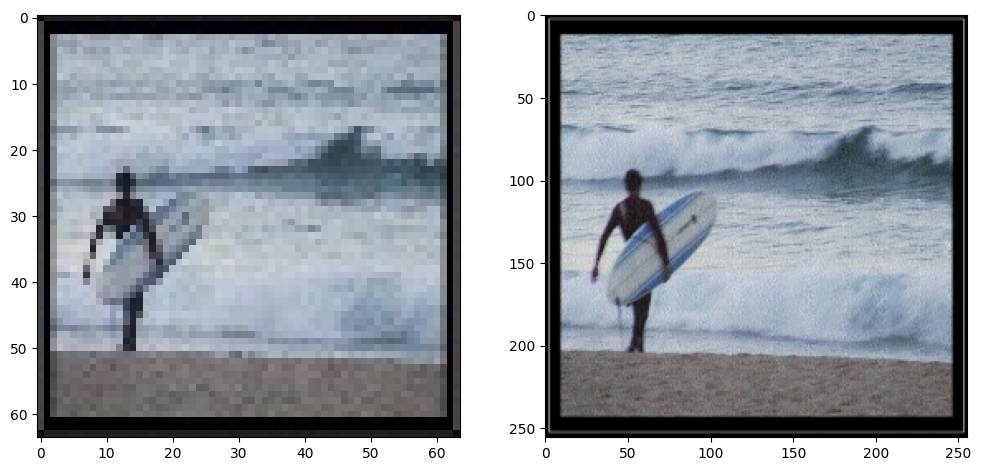

In [26]:
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (64, 64, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number]*0.5 + 0.5, (256, 256, 3)))
plt.show()

In [27]:
#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.2, random_state=42)

In [28]:
with tf.device('/cpu:0'):
    # Create TensorFlow dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((lr_train, hr_train))

    # Shuffle and batch the dataset
    train_dataset = train_dataset.shuffle(buffer_size=160).batch(1)

In [29]:
# Print the number of samples in the training dataset
print("Number of samples in the training dataset:", len(train_dataset))

Number of samples in the training dataset: 160


In [32]:
num_epochs=500
batch_size=1

In [33]:
# Training loop
for epoch in range(num_epochs):
    print("Epoch:", epoch)

    progress_bar = tqdm(train_dataset, desc=f'Epoch {epoch}/{num_epochs}', unit='batch')

    for batch, (lr_train, hr_train) in enumerate(progress_bar):
        gen_loss, disc_loss = train_step(lr_train, hr_train)

        # Print losses for progress monitoring
        progress_bar.set_postfix({'Generator Loss': gen_loss.numpy(), 'Discriminator Loss': disc_loss.numpy()})


Epoch: 0


Epoch 0/500: 100%|██████████| 160/160 [00:25<00:00,  6.27batch/s, Generator Loss=0.0504, Discriminator Loss=5.8e-19] 


Epoch: 1


Epoch 1/500: 100%|██████████| 160/160 [00:25<00:00,  6.21batch/s, Generator Loss=0.0189, Discriminator Loss=6.02e-9] 


Epoch: 2


Epoch 2/500: 100%|██████████| 160/160 [00:25<00:00,  6.25batch/s, Generator Loss=0.0534, Discriminator Loss=0.000157] 


Epoch: 3


Epoch 3/500: 100%|██████████| 160/160 [00:25<00:00,  6.25batch/s, Generator Loss=0.0363, Discriminator Loss=3.73e-15]


Epoch: 4


Epoch 4/500: 100%|██████████| 160/160 [00:25<00:00,  6.25batch/s, Generator Loss=0.000239, Discriminator Loss=3.13]   


Epoch: 5


Epoch 5/500: 100%|██████████| 160/160 [00:25<00:00,  6.24batch/s, Generator Loss=0.0266, Discriminator Loss=1.45]     


Epoch: 6


Epoch 6/500: 100%|██████████| 160/160 [00:25<00:00,  6.24batch/s, Generator Loss=0.000141, Discriminator Loss=10.9]  


Epoch: 7


Epoch 7/500: 100%|██████████| 160/160 [00:25<00:00,  6.24batch/s, Generator Loss=0.0291, Discriminator Loss=6.69e-11] 


Epoch: 8


Epoch 8/500: 100%|██████████| 160/160 [00:25<00:00,  6.24batch/s, Generator Loss=0.0231, Discriminator Loss=3.06e-10] 


Epoch: 9


Epoch 9/500: 100%|██████████| 160/160 [00:25<00:00,  6.24batch/s, Generator Loss=0.0516, Discriminator Loss=3.22e-11]


Epoch: 10


Epoch 10/500: 100%|██████████| 160/160 [00:25<00:00,  6.24batch/s, Generator Loss=0.00912, Discriminator Loss=0.00425] 


Epoch: 11


Epoch 11/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0251, Discriminator Loss=1.08]     


Epoch: 12


Epoch 12/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.024, Discriminator Loss=6.56]      


Epoch: 13


Epoch 13/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0213, Discriminator Loss=9.01]     


Epoch: 14


Epoch 14/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0133, Discriminator Loss=3.04e-6]  


Epoch: 15


Epoch 15/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0239, Discriminator Loss=0.484]    


Epoch: 16


Epoch 16/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00073, Discriminator Loss=7.77]    


Epoch: 17


Epoch 17/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0108, Discriminator Loss=5.79e-5]  


Epoch: 18


Epoch 18/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00819, Discriminator Loss=0.315]  


Epoch: 19


Epoch 19/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0146, Discriminator Loss=0.00225] 


Epoch: 20


Epoch 20/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0114, Discriminator Loss=1.38e-5]  


Epoch: 21


Epoch 21/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0111, Discriminator Loss=0.000933] 


Epoch: 22


Epoch 22/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.025, Discriminator Loss=1.75e-8]   


Epoch: 23


Epoch 23/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0383, Discriminator Loss=1.68]     


Epoch: 24


Epoch 24/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00515, Discriminator Loss=0.00698] 


Epoch: 25


Epoch 25/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0139, Discriminator Loss=7.77e-6]  


Epoch: 26


Epoch 26/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0546, Discriminator Loss=5.78]     


Epoch: 27


Epoch 27/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0107, Discriminator Loss=3.92e-5]  


Epoch: 28


Epoch 28/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00655, Discriminator Loss=0.00295] 


Epoch: 29


Epoch 29/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0149, Discriminator Loss=0.0306]   


Epoch: 30


Epoch 30/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.011, Discriminator Loss=0.00772]   


Epoch: 31


Epoch 31/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00843, Discriminator Loss=0.00038] 


Epoch: 32


Epoch 32/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00638, Discriminator Loss=0.00313] 


Epoch: 33


Epoch 33/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0117, Discriminator Loss=1.44e-5]  


Epoch: 34


Epoch 34/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0128, Discriminator Loss=1.14e-5]  


Epoch: 35


Epoch 35/500: 100%|██████████| 160/160 [00:25<00:00,  6.19batch/s, Generator Loss=0.00631, Discriminator Loss=0.00238] 


Epoch: 36


Epoch 36/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0215, Discriminator Loss=1.14e-6]  


Epoch: 37


Epoch 37/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0135, Discriminator Loss=0.00103]  


Epoch: 38


Epoch 38/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0154, Discriminator Loss=5.01e-5]  


Epoch: 39


Epoch 39/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.015, Discriminator Loss=2.62e-6]   


Epoch: 40


Epoch 40/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0102, Discriminator Loss=5.62e-5]  


Epoch: 41


Epoch 41/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0102, Discriminator Loss=0.000108] 


Epoch: 42


Epoch 42/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00783, Discriminator Loss=0.000597]


Epoch: 43


Epoch 43/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0106, Discriminator Loss=2]        


Epoch: 44


Epoch 44/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00522, Discriminator Loss=0.0417]  


Epoch: 45


Epoch 45/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0102, Discriminator Loss=0.684]    


Epoch: 46


Epoch 46/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00835, Discriminator Loss=0.786]   


Epoch: 47


Epoch 47/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0113, Discriminator Loss=0.151]    


Epoch: 48


Epoch 48/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00823, Discriminator Loss=0.000883]


Epoch: 49


Epoch 49/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00907, Discriminator Loss=0.000185]


Epoch: 50


Epoch 50/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00963, Discriminator Loss=9.52e-5] 


Epoch: 51


Epoch 51/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00138, Discriminator Loss=1.36]    


Epoch: 52


Epoch 52/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00993, Discriminator Loss=6.82e-5] 


Epoch: 53


Epoch 53/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0106, Discriminator Loss=2.61e-5]  


Epoch: 54


Epoch 54/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00824, Discriminator Loss=0.000385]


Epoch: 55


Epoch 55/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0186, Discriminator Loss=0.335]    


Epoch: 56


Epoch 56/500: 100%|██████████| 160/160 [00:25<00:00,  6.18batch/s, Generator Loss=0.00782, Discriminator Loss=0.000548]


Epoch: 57


Epoch 57/500: 100%|██████████| 160/160 [00:25<00:00,  6.21batch/s, Generator Loss=0.00326, Discriminator Loss=0.0442]  


Epoch: 58


Epoch 58/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00222, Discriminator Loss=0.167]   


Epoch: 59


Epoch 59/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00223, Discriminator Loss=0.116]   


Epoch: 60


Epoch 60/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0104, Discriminator Loss=6.62e-5]  


Epoch: 61


Epoch 61/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0212, Discriminator Loss=0.00935]  


Epoch: 62


Epoch 62/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00956, Discriminator Loss=8.13e-5] 


Epoch: 63


Epoch 63/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0107, Discriminator Loss=0.000343] 


Epoch: 64


Epoch 64/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0038, Discriminator Loss=2.21]     


Epoch: 65


Epoch 65/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00612, Discriminator Loss=0.00271] 


Epoch: 66


Epoch 66/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0233, Discriminator Loss=0.00248]  


Epoch: 67


Epoch 67/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0104, Discriminator Loss=0.0012]   


Epoch: 68


Epoch 68/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0211, Discriminator Loss=0.00574]  


Epoch: 69


Epoch 69/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00124, Discriminator Loss=0.38]    


Epoch: 70


Epoch 70/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00532, Discriminator Loss=0.00919] 


Epoch: 71


Epoch 71/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00448, Discriminator Loss=0.0125]  


Epoch: 72


Epoch 72/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0164, Discriminator Loss=0.000473] 


Epoch: 73


Epoch 73/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.000979, Discriminator Loss=0.516]  


Epoch: 74


Epoch 74/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0198, Discriminator Loss=0.0257]   


Epoch: 75


Epoch 75/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00884, Discriminator Loss=0.000159]


Epoch: 76


Epoch 76/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00982, Discriminator Loss=0.00641] 


Epoch: 77


Epoch 77/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00387, Discriminator Loss=0.0218]  


Epoch: 78


Epoch 78/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0165, Discriminator Loss=0.0795]   


Epoch: 79


Epoch 79/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00749, Discriminator Loss=0.000586]


Epoch: 80


Epoch 80/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00114, Discriminator Loss=0.411]   


Epoch: 81


Epoch 81/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00461, Discriminator Loss=0.0214]  


Epoch: 82


Epoch 82/500: 100%|██████████| 160/160 [00:25<00:00,  6.21batch/s, Generator Loss=0.0136, Discriminator Loss=0.0554]   


Epoch: 83


Epoch 83/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00372, Discriminator Loss=0.0321]  


Epoch: 84


Epoch 84/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0122, Discriminator Loss=5.6e-6]   


Epoch: 85


Epoch 85/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0109, Discriminator Loss=0.256]    


Epoch: 86


Epoch 86/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0191, Discriminator Loss=0.0449]   


Epoch: 87


Epoch 87/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00902, Discriminator Loss=0.000578]


Epoch: 88


Epoch 88/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00491, Discriminator Loss=0.0117]  


Epoch: 89


Epoch 89/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00909, Discriminator Loss=0.883]   


Epoch: 90


Epoch 90/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00537, Discriminator Loss=0.0108]  


Epoch: 91


Epoch 91/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0167, Discriminator Loss=0.649]    


Epoch: 92


Epoch 92/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00304, Discriminator Loss=0.0562]  


Epoch: 93


Epoch 93/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0185, Discriminator Loss=8.16e-5]  


Epoch: 94


Epoch 94/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0136, Discriminator Loss=0.00606]  


Epoch: 95


Epoch 95/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00745, Discriminator Loss=0.000612]


Epoch: 96


Epoch 96/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0146, Discriminator Loss=5.06e-7]  


Epoch: 97


Epoch 97/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00691, Discriminator Loss=0.00167] 


Epoch: 98


Epoch 98/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0103, Discriminator Loss=0.72]     


Epoch: 99


Epoch 99/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0115, Discriminator Loss=0.00103]  


Epoch: 100


Epoch 100/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00567, Discriminator Loss=0.00478] 


Epoch: 101


Epoch 101/500: 100%|██████████| 160/160 [00:25<00:00,  6.21batch/s, Generator Loss=0.0118, Discriminator Loss=0.00112]  


Epoch: 102


Epoch 102/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00774, Discriminator Loss=0.000553]


Epoch: 103


Epoch 103/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00601, Discriminator Loss=0.00252] 


Epoch: 104


Epoch 104/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00715, Discriminator Loss=0.0149]  


Epoch: 105


Epoch 105/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00401, Discriminator Loss=0.0417]  


Epoch: 106


Epoch 106/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00965, Discriminator Loss=7.03e-5] 


Epoch: 107


Epoch 107/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0046, Discriminator Loss=0.0121]   


Epoch: 108


Epoch 108/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0133, Discriminator Loss=4.95e-6]  


Epoch: 109


Epoch 109/500: 100%|██████████| 160/160 [00:25<00:00,  6.23batch/s, Generator Loss=0.0117, Discriminator Loss=7e-5]     


Epoch: 110


Epoch 110/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00534, Discriminator Loss=0.00624] 


Epoch: 111


Epoch 111/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00812, Discriminator Loss=0.0003]  


Epoch: 112


Epoch 112/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00613, Discriminator Loss=0.00224] 


Epoch: 113


Epoch 113/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00218, Discriminator Loss=0.162]   


Epoch: 114


Epoch 114/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0195, Discriminator Loss=7.42e-8]  


Epoch: 115


Epoch 115/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00535, Discriminator Loss=0.0678]  


Epoch: 116


Epoch 116/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00124, Discriminator Loss=0.438]   


Epoch: 117


Epoch 117/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0121, Discriminator Loss=5.37e-6]  


Epoch: 118


Epoch 118/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00602, Discriminator Loss=0.00381] 


Epoch: 119


Epoch 119/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0045, Discriminator Loss=0.0216]   


Epoch: 120


Epoch 120/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00549, Discriminator Loss=0.00471] 


Epoch: 121


Epoch 121/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0127, Discriminator Loss=0.175]    


Epoch: 122


Epoch 122/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00585, Discriminator Loss=0.00363] 


Epoch: 123


Epoch 123/500: 100%|██████████| 160/160 [00:25<00:00,  6.21batch/s, Generator Loss=0.0297, Discriminator Loss=1.45e-13] 


Epoch: 124


Epoch 124/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00769, Discriminator Loss=0.000554]


Epoch: 125


Epoch 125/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00799, Discriminator Loss=0.00142] 


Epoch: 126


Epoch 126/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00426, Discriminator Loss=0.0147]  


Epoch: 127


Epoch 127/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00687, Discriminator Loss=0.00122] 


Epoch: 128


Epoch 128/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0107, Discriminator Loss=2.45e-5]  


Epoch: 129


Epoch 129/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0108, Discriminator Loss=2.04e-5]  


Epoch: 130


Epoch 130/500: 100%|██████████| 160/160 [00:25<00:00,  6.21batch/s, Generator Loss=0.00834, Discriminator Loss=0.00112] 


Epoch: 131


Epoch 131/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0109, Discriminator Loss=0.372]    


Epoch: 132


Epoch 132/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0152, Discriminator Loss=3.33e-7]  


Epoch: 133


Epoch 133/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00991, Discriminator Loss=6.52e-5] 


Epoch: 134


Epoch 134/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.016, Discriminator Loss=0.000852]  


Epoch: 135


Epoch 135/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0109, Discriminator Loss=1.94e-5]  


Epoch: 136


Epoch 136/500: 100%|██████████| 160/160 [00:25<00:00,  6.16batch/s, Generator Loss=0.00366, Discriminator Loss=0.0273]  


Epoch: 137


Epoch 137/500: 100%|██████████| 160/160 [00:26<00:00,  6.03batch/s, Generator Loss=0.015, Discriminator Loss=3.61e-7]   


Epoch: 138


Epoch 138/500: 100%|██████████| 160/160 [00:26<00:00,  6.05batch/s, Generator Loss=0.0056, Discriminator Loss=0.00396]  


Epoch: 139


Epoch 139/500: 100%|██████████| 160/160 [00:26<00:00,  6.02batch/s, Generator Loss=0.00754, Discriminator Loss=0.000535]


Epoch: 140


Epoch 140/500: 100%|██████████| 160/160 [00:26<00:00,  6.05batch/s, Generator Loss=0.00889, Discriminator Loss=0.05]    


Epoch: 141


Epoch 141/500: 100%|██████████| 160/160 [00:26<00:00,  6.03batch/s, Generator Loss=0.01, Discriminator Loss=4.65e-5]    


Epoch: 142


Epoch 142/500: 100%|██████████| 160/160 [00:26<00:00,  6.03batch/s, Generator Loss=0.00824, Discriminator Loss=0.000302]


Epoch: 143


Epoch 143/500: 100%|██████████| 160/160 [00:26<00:00,  6.06batch/s, Generator Loss=0.0119, Discriminator Loss=7.43e-6]  


Epoch: 144


Epoch 144/500: 100%|██████████| 160/160 [00:26<00:00,  6.02batch/s, Generator Loss=0.00222, Discriminator Loss=0.115]   


Epoch: 145


Epoch 145/500: 100%|██████████| 160/160 [00:26<00:00,  6.04batch/s, Generator Loss=0.0118, Discriminator Loss=0.0181]   


Epoch: 146


Epoch 146/500: 100%|██████████| 160/160 [00:26<00:00,  6.05batch/s, Generator Loss=0.00954, Discriminator Loss=0.000187]


Epoch: 147


Epoch 147/500: 100%|██████████| 160/160 [00:26<00:00,  6.02batch/s, Generator Loss=0.00942, Discriminator Loss=9.64e-5] 


Epoch: 148


Epoch 148/500: 100%|██████████| 160/160 [00:26<00:00,  6.07batch/s, Generator Loss=0.00974, Discriminator Loss=7.49e-5] 


Epoch: 149


Epoch 149/500: 100%|██████████| 160/160 [00:26<00:00,  6.03batch/s, Generator Loss=0.00841, Discriminator Loss=0.000244]


Epoch: 150


Epoch 150/500: 100%|██████████| 160/160 [00:26<00:00,  6.04batch/s, Generator Loss=0.01, Discriminator Loss=0.00236]    


Epoch: 151


Epoch 151/500: 100%|██████████| 160/160 [00:26<00:00,  6.04batch/s, Generator Loss=0.0104, Discriminator Loss=0.000669] 


Epoch: 152


Epoch 152/500: 100%|██████████| 160/160 [00:26<00:00,  6.02batch/s, Generator Loss=0.00288, Discriminator Loss=0.0605]  


Epoch: 153


Epoch 153/500: 100%|██████████| 160/160 [00:26<00:00,  6.07batch/s, Generator Loss=0.00791, Discriminator Loss=0.000375]


Epoch: 154


Epoch 154/500: 100%|██████████| 160/160 [00:26<00:00,  6.02batch/s, Generator Loss=0.0132, Discriminator Loss=2.39e-6]  


Epoch: 155


Epoch 155/500: 100%|██████████| 160/160 [00:26<00:00,  6.04batch/s, Generator Loss=0.00686, Discriminator Loss=0.00108] 


Epoch: 156


Epoch 156/500: 100%|██████████| 160/160 [00:26<00:00,  6.06batch/s, Generator Loss=0.00692, Discriminator Loss=0.00108] 


Epoch: 157


Epoch 157/500: 100%|██████████| 160/160 [00:26<00:00,  6.01batch/s, Generator Loss=0.00437, Discriminator Loss=0.0147]  


Epoch: 158


Epoch 158/500: 100%|██████████| 160/160 [00:26<00:00,  6.06batch/s, Generator Loss=0.0141, Discriminator Loss=1.22e-5]  


Epoch: 159


Epoch 159/500: 100%|██████████| 160/160 [00:26<00:00,  6.03batch/s, Generator Loss=0.0131, Discriminator Loss=3.58e-6]  


Epoch: 160


Epoch 160/500: 100%|██████████| 160/160 [00:26<00:00,  6.03batch/s, Generator Loss=0.012, Discriminator Loss=1.65e-5]   


Epoch: 161


Epoch 161/500: 100%|██████████| 160/160 [00:26<00:00,  6.07batch/s, Generator Loss=0.00701, Discriminator Loss=0.000931]


Epoch: 162


Epoch 162/500: 100%|██████████| 160/160 [00:26<00:00,  6.02batch/s, Generator Loss=0.00911, Discriminator Loss=0.000112]


Epoch: 163


Epoch 163/500: 100%|██████████| 160/160 [00:26<00:00,  6.04batch/s, Generator Loss=0.00573, Discriminator Loss=0.00349] 


Epoch: 164


Epoch 164/500: 100%|██████████| 160/160 [00:26<00:00,  6.04batch/s, Generator Loss=0.0118, Discriminator Loss=8.72e-6]  


Epoch: 165


Epoch 165/500: 100%|██████████| 160/160 [00:26<00:00,  5.99batch/s, Generator Loss=0.00747, Discriminator Loss=0.000604]


Epoch: 166


Epoch 166/500: 100%|██████████| 160/160 [00:26<00:00,  6.07batch/s, Generator Loss=0.0126, Discriminator Loss=8.35e-5]  


Epoch: 167


Epoch 167/500: 100%|██████████| 160/160 [00:26<00:00,  5.99batch/s, Generator Loss=0.00529, Discriminator Loss=0.00528] 


Epoch: 168


Epoch 168/500: 100%|██████████| 160/160 [00:26<00:00,  6.13batch/s, Generator Loss=0.00718, Discriminator Loss=0.000784]


Epoch: 169


Epoch 169/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00674, Discriminator Loss=0.00323] 


Epoch: 170


Epoch 170/500: 100%|██████████| 160/160 [00:25<00:00,  6.21batch/s, Generator Loss=0.0158, Discriminator Loss=0.00842]  


Epoch: 171


Epoch 171/500: 100%|██████████| 160/160 [00:25<00:00,  6.23batch/s, Generator Loss=0.00583, Discriminator Loss=0.00397] 


Epoch: 172


Epoch 172/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00627, Discriminator Loss=0.00207] 


Epoch: 173


Epoch 173/500: 100%|██████████| 160/160 [00:25<00:00,  6.24batch/s, Generator Loss=0.0106, Discriminator Loss=2.89e-5]  


Epoch: 174


Epoch 174/500: 100%|██████████| 160/160 [00:25<00:00,  6.27batch/s, Generator Loss=0.0113, Discriminator Loss=9.5e-5]   


Epoch: 175


Epoch 175/500: 100%|██████████| 160/160 [00:25<00:00,  6.24batch/s, Generator Loss=0.00603, Discriminator Loss=0.00408] 


Epoch: 176


Epoch 176/500: 100%|██████████| 160/160 [00:25<00:00,  6.31batch/s, Generator Loss=0.00726, Discriminator Loss=0.00105] 


Epoch: 177


Epoch 177/500: 100%|██████████| 160/160 [00:25<00:00,  6.24batch/s, Generator Loss=0.00928, Discriminator Loss=0.000102]


Epoch: 178


Epoch 178/500: 100%|██████████| 160/160 [00:26<00:00,  6.15batch/s, Generator Loss=0.0113, Discriminator Loss=1.47e-5]  


Epoch: 179


Epoch 179/500: 100%|██████████| 160/160 [00:25<00:00,  6.30batch/s, Generator Loss=0.0087, Discriminator Loss=0.000178] 


Epoch: 180


Epoch 180/500: 100%|██████████| 160/160 [00:25<00:00,  6.18batch/s, Generator Loss=0.0163, Discriminator Loss=1.2e-5]   


Epoch: 181


Epoch 181/500: 100%|██████████| 160/160 [00:25<00:00,  6.27batch/s, Generator Loss=0.0114, Discriminator Loss=0.000972] 


Epoch: 182


Epoch 182/500: 100%|██████████| 160/160 [00:25<00:00,  6.27batch/s, Generator Loss=0.00917, Discriminator Loss=0.000373]


Epoch: 183


Epoch 183/500: 100%|██████████| 160/160 [00:25<00:00,  6.27batch/s, Generator Loss=0.0122, Discriminator Loss=8.74e-6]  


Epoch: 184


Epoch 184/500: 100%|██████████| 160/160 [00:25<00:00,  6.29batch/s, Generator Loss=0.00143, Discriminator Loss=0.481]   


Epoch: 185


Epoch 185/500: 100%|██████████| 160/160 [00:25<00:00,  6.31batch/s, Generator Loss=0.00908, Discriminator Loss=0.000119]


Epoch: 186


Epoch 186/500: 100%|██████████| 160/160 [00:25<00:00,  6.30batch/s, Generator Loss=0.016, Discriminator Loss=4.26e-5]   


Epoch: 187


Epoch 187/500: 100%|██████████| 160/160 [00:25<00:00,  6.31batch/s, Generator Loss=0.00203, Discriminator Loss=0.149]   


Epoch: 188


Epoch 188/500: 100%|██████████| 160/160 [00:25<00:00,  6.27batch/s, Generator Loss=0.00609, Discriminator Loss=0.00263] 


Epoch: 189


Epoch 189/500: 100%|██████████| 160/160 [00:25<00:00,  6.23batch/s, Generator Loss=0.00541, Discriminator Loss=0.00533] 


Epoch: 190


Epoch 190/500: 100%|██████████| 160/160 [00:25<00:00,  6.30batch/s, Generator Loss=0.00528, Discriminator Loss=0.00583] 


Epoch: 191


Epoch 191/500: 100%|██████████| 160/160 [00:25<00:00,  6.29batch/s, Generator Loss=0.0083, Discriminator Loss=0.000286] 


Epoch: 192


Epoch 192/500: 100%|██████████| 160/160 [00:25<00:00,  6.32batch/s, Generator Loss=0.011, Discriminator Loss=0.00187]   


Epoch: 193


Epoch 193/500: 100%|██████████| 160/160 [00:25<00:00,  6.30batch/s, Generator Loss=0.00833, Discriminator Loss=0.000305]


Epoch: 194


Epoch 194/500: 100%|██████████| 160/160 [00:25<00:00,  6.31batch/s, Generator Loss=0.0103, Discriminator Loss=4.2e-5]   


Epoch: 195


Epoch 195/500: 100%|██████████| 160/160 [00:25<00:00,  6.29batch/s, Generator Loss=0.0193, Discriminator Loss=1.04e-7]  


Epoch: 196


Epoch 196/500: 100%|██████████| 160/160 [00:25<00:00,  6.31batch/s, Generator Loss=0.0019, Discriminator Loss=0.165]    


Epoch: 197


Epoch 197/500: 100%|██████████| 160/160 [00:25<00:00,  6.33batch/s, Generator Loss=0.0125, Discriminator Loss=0.000145] 


Epoch: 198


Epoch 198/500: 100%|██████████| 160/160 [00:25<00:00,  6.30batch/s, Generator Loss=0.0133, Discriminator Loss=6.5e-6]   


Epoch: 199


Epoch 199/500: 100%|██████████| 160/160 [00:25<00:00,  6.34batch/s, Generator Loss=0.0121, Discriminator Loss=0.000294] 


Epoch: 200


Epoch 200/500: 100%|██████████| 160/160 [00:25<00:00,  6.33batch/s, Generator Loss=0.00852, Discriminator Loss=0.00124] 


Epoch: 201


Epoch 201/500: 100%|██████████| 160/160 [00:25<00:00,  6.25batch/s, Generator Loss=0.00947, Discriminator Loss=8.92e-5] 


Epoch: 202


Epoch 202/500: 100%|██████████| 160/160 [00:25<00:00,  6.31batch/s, Generator Loss=0.0139, Discriminator Loss=1.2e-6]   


Epoch: 203


Epoch 203/500: 100%|██████████| 160/160 [00:25<00:00,  6.31batch/s, Generator Loss=0.0159, Discriminator Loss=0.125]    


Epoch: 204


Epoch 204/500: 100%|██████████| 160/160 [00:25<00:00,  6.26batch/s, Generator Loss=0.0145, Discriminator Loss=0.0339]   


Epoch: 205


Epoch 205/500: 100%|██████████| 160/160 [00:25<00:00,  6.35batch/s, Generator Loss=0.00241, Discriminator Loss=0.116]   


Epoch: 206


Epoch 206/500: 100%|██████████| 160/160 [00:25<00:00,  6.32batch/s, Generator Loss=0.0111, Discriminator Loss=1.5e-5]   


Epoch: 207


Epoch 207/500: 100%|██████████| 160/160 [00:25<00:00,  6.25batch/s, Generator Loss=0.0029, Discriminator Loss=0.0611]   


Epoch: 208


Epoch 208/500: 100%|██████████| 160/160 [00:25<00:00,  6.23batch/s, Generator Loss=0.00622, Discriminator Loss=0.00215] 


Epoch: 209


Epoch 209/500: 100%|██████████| 160/160 [00:25<00:00,  6.24batch/s, Generator Loss=0.0115, Discriminator Loss=0.00374]  


Epoch: 210


Epoch 210/500: 100%|██████████| 160/160 [00:25<00:00,  6.29batch/s, Generator Loss=0.0134, Discriminator Loss=7.04e-6]  


Epoch: 211


Epoch 211/500: 100%|██████████| 160/160 [00:25<00:00,  6.28batch/s, Generator Loss=0.0154, Discriminator Loss=7.42e-5]  


Epoch: 212


Epoch 212/500: 100%|██████████| 160/160 [00:25<00:00,  6.31batch/s, Generator Loss=0.012, Discriminator Loss=0.00472]   


Epoch: 213


Epoch 213/500: 100%|██████████| 160/160 [00:25<00:00,  6.33batch/s, Generator Loss=0.0116, Discriminator Loss=1.06e-5]  


Epoch: 214


Epoch 214/500: 100%|██████████| 160/160 [00:25<00:00,  6.36batch/s, Generator Loss=0.0103, Discriminator Loss=0.00013]  


Epoch: 215


Epoch 215/500: 100%|██████████| 160/160 [00:25<00:00,  6.31batch/s, Generator Loss=0.0187, Discriminator Loss=8.18e-9]  


Epoch: 216


Epoch 216/500: 100%|██████████| 160/160 [00:25<00:00,  6.30batch/s, Generator Loss=0.00952, Discriminator Loss=9.06e-5] 


Epoch: 217


Epoch 217/500: 100%|██████████| 160/160 [00:25<00:00,  6.31batch/s, Generator Loss=0.0137, Discriminator Loss=1.75e-6]  


Epoch: 218


Epoch 218/500: 100%|██████████| 160/160 [00:25<00:00,  6.31batch/s, Generator Loss=0.00282, Discriminator Loss=0.0731]  


Epoch: 219


Epoch 219/500: 100%|██████████| 160/160 [00:25<00:00,  6.31batch/s, Generator Loss=0.0152, Discriminator Loss=2.62e-7]  


Epoch: 220


Epoch 220/500: 100%|██████████| 160/160 [00:25<00:00,  6.27batch/s, Generator Loss=0.0104, Discriminator Loss=0.000235] 


Epoch: 221


Epoch 221/500: 100%|██████████| 160/160 [00:25<00:00,  6.34batch/s, Generator Loss=0.0162, Discriminator Loss=9.46e-8]  


Epoch: 222


Epoch 222/500: 100%|██████████| 160/160 [00:25<00:00,  6.29batch/s, Generator Loss=0.00941, Discriminator Loss=9.37e-5] 


Epoch: 223


Epoch 223/500: 100%|██████████| 160/160 [00:25<00:00,  6.26batch/s, Generator Loss=0.00612, Discriminator Loss=0.00225] 


Epoch: 224


Epoch 224/500: 100%|██████████| 160/160 [00:25<00:00,  6.29batch/s, Generator Loss=0.0164, Discriminator Loss=0.0139]   


Epoch: 225


Epoch 225/500: 100%|██████████| 160/160 [00:25<00:00,  6.29batch/s, Generator Loss=0.0102, Discriminator Loss=0.00331]  


Epoch: 226


Epoch 226/500: 100%|██████████| 160/160 [00:25<00:00,  6.33batch/s, Generator Loss=0.0101, Discriminator Loss=5.22e-5]  


Epoch: 227


Epoch 227/500: 100%|██████████| 160/160 [00:25<00:00,  6.33batch/s, Generator Loss=0.0159, Discriminator Loss=0.0293]   


Epoch: 228


Epoch 228/500: 100%|██████████| 160/160 [00:25<00:00,  6.32batch/s, Generator Loss=0.0122, Discriminator Loss=0.00678]  


Epoch: 229


Epoch 229/500: 100%|██████████| 160/160 [00:25<00:00,  6.26batch/s, Generator Loss=0.00635, Discriminator Loss=0.00183] 


Epoch: 230


Epoch 230/500: 100%|██████████| 160/160 [00:25<00:00,  6.24batch/s, Generator Loss=0.00626, Discriminator Loss=0.0031]  


Epoch: 231


Epoch 231/500: 100%|██████████| 160/160 [00:25<00:00,  6.29batch/s, Generator Loss=0.0137, Discriminator Loss=0.000767] 


Epoch: 232


Epoch 232/500: 100%|██████████| 160/160 [00:25<00:00,  6.26batch/s, Generator Loss=0.00732, Discriminator Loss=0.000663]


Epoch: 233


Epoch 233/500: 100%|██████████| 160/160 [00:25<00:00,  6.25batch/s, Generator Loss=0.00912, Discriminator Loss=0.000124]


Epoch: 234


Epoch 234/500: 100%|██████████| 160/160 [00:25<00:00,  6.28batch/s, Generator Loss=0.0177, Discriminator Loss=0.225]    


Epoch: 235


Epoch 235/500: 100%|██████████| 160/160 [00:25<00:00,  6.35batch/s, Generator Loss=0.00404, Discriminator Loss=0.0252]  


Epoch: 236


Epoch 236/500: 100%|██████████| 160/160 [00:25<00:00,  6.28batch/s, Generator Loss=0.013, Discriminator Loss=0.291]     


Epoch: 237


Epoch 237/500: 100%|██████████| 160/160 [00:26<00:00,  6.09batch/s, Generator Loss=0.00853, Discriminator Loss=0.000214]


Epoch: 238


Epoch 238/500: 100%|██████████| 160/160 [00:25<00:00,  6.21batch/s, Generator Loss=0.0108, Discriminator Loss=2.23e-5]  


Epoch: 239


Epoch 239/500: 100%|██████████| 160/160 [00:25<00:00,  6.18batch/s, Generator Loss=0.0116, Discriminator Loss=5.38e-5]  


Epoch: 240


Epoch 240/500: 100%|██████████| 160/160 [00:25<00:00,  6.19batch/s, Generator Loss=0.0134, Discriminator Loss=1.8e-6]   


Epoch: 241


Epoch 241/500: 100%|██████████| 160/160 [00:25<00:00,  6.34batch/s, Generator Loss=0.00841, Discriminator Loss=0.000468]


Epoch: 242


Epoch 242/500: 100%|██████████| 160/160 [00:25<00:00,  6.19batch/s, Generator Loss=0.0105, Discriminator Loss=6.42e-5]  


Epoch: 243


Epoch 243/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0117, Discriminator Loss=1.71e-5]  


Epoch: 244


Epoch 244/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.01, Discriminator Loss=0.000224]   


Epoch: 245


Epoch 245/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00569, Discriminator Loss=0.00459] 


Epoch: 246


Epoch 246/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0192, Discriminator Loss=0.000186] 


Epoch: 247


Epoch 247/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00736, Discriminator Loss=0.000695]


Epoch: 248


Epoch 248/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0104, Discriminator Loss=3.23e-5]  


Epoch: 249


Epoch 249/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.013, Discriminator Loss=5.22e-6]   


Epoch: 250


Epoch 250/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0131, Discriminator Loss=2.15e-6]  


Epoch: 251


Epoch 251/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00863, Discriminator Loss=0.000219]


Epoch: 252


Epoch 252/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0106, Discriminator Loss=5.53e-5]  


Epoch: 253


Epoch 253/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00466, Discriminator Loss=0.0105]  


Epoch: 254


Epoch 254/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0145, Discriminator Loss=8.81e-7]  


Epoch: 255


Epoch 255/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0198, Discriminator Loss=5.2e-6]   


Epoch: 256


Epoch 256/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00975, Discriminator Loss=6.52e-5] 


Epoch: 257


Epoch 257/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0124, Discriminator Loss=1.58e-5]  


Epoch: 258


Epoch 258/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00982, Discriminator Loss=5.51e-5] 


Epoch: 259


Epoch 259/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0139, Discriminator Loss=0.00128]  


Epoch: 260


Epoch 260/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00493, Discriminator Loss=0.00813] 


Epoch: 261


Epoch 261/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00276, Discriminator Loss=0.0725]  


Epoch: 262


Epoch 262/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0126, Discriminator Loss=3.57e-6]  


Epoch: 263


Epoch 263/500: 100%|██████████| 160/160 [00:26<00:00,  6.14batch/s, Generator Loss=0.00839, Discriminator Loss=0.000237]


Epoch: 264


Epoch 264/500: 100%|██████████| 160/160 [00:25<00:00,  6.23batch/s, Generator Loss=0.00437, Discriminator Loss=0.0133]  


Epoch: 265


Epoch 265/500: 100%|██████████| 160/160 [00:25<00:00,  6.16batch/s, Generator Loss=0.0117, Discriminator Loss=8.6e-6]   


Epoch: 266


Epoch 266/500: 100%|██████████| 160/160 [00:25<00:00,  6.19batch/s, Generator Loss=0.0142, Discriminator Loss=4.15e-5]  


Epoch: 267


Epoch 267/500: 100%|██████████| 160/160 [00:25<00:00,  6.29batch/s, Generator Loss=0.0122, Discriminator Loss=5.89e-6]  


Epoch: 268


Epoch 268/500: 100%|██████████| 160/160 [00:25<00:00,  6.29batch/s, Generator Loss=0.0046, Discriminator Loss=0.0104]   


Epoch: 269


Epoch 269/500: 100%|██████████| 160/160 [00:25<00:00,  6.19batch/s, Generator Loss=0.0118, Discriminator Loss=2.92e-5]  


Epoch: 270


Epoch 270/500: 100%|██████████| 160/160 [00:26<00:00,  6.15batch/s, Generator Loss=0.0159, Discriminator Loss=0.046]    


Epoch: 271


Epoch 271/500: 100%|██████████| 160/160 [00:25<00:00,  6.20batch/s, Generator Loss=0.0185, Discriminator Loss=4.56e-5]  


Epoch: 272


Epoch 272/500: 100%|██████████| 160/160 [00:25<00:00,  6.19batch/s, Generator Loss=0.00578, Discriminator Loss=0.00374] 


Epoch: 273


Epoch 273/500: 100%|██████████| 160/160 [00:26<00:00,  6.15batch/s, Generator Loss=0.0177, Discriminator Loss=6.63e-7]  


Epoch: 274


Epoch 274/500: 100%|██████████| 160/160 [00:25<00:00,  6.28batch/s, Generator Loss=0.0171, Discriminator Loss=8.76e-8]  


Epoch: 275


Epoch 275/500: 100%|██████████| 160/160 [00:25<00:00,  6.28batch/s, Generator Loss=0.0102, Discriminator Loss=0.000801] 


Epoch: 276


Epoch 276/500: 100%|██████████| 160/160 [00:25<00:00,  6.23batch/s, Generator Loss=0.00988, Discriminator Loss=5.75e-5] 


Epoch: 277


Epoch 277/500: 100%|██████████| 160/160 [00:25<00:00,  6.21batch/s, Generator Loss=0.0179, Discriminator Loss=2.8e-7]   


Epoch: 278


Epoch 278/500: 100%|██████████| 160/160 [00:25<00:00,  6.26batch/s, Generator Loss=0.0176, Discriminator Loss=2.4e-8]   


Epoch: 279


Epoch 279/500: 100%|██████████| 160/160 [00:25<00:00,  6.20batch/s, Generator Loss=0.0106, Discriminator Loss=6.06e-5]  


Epoch: 280


Epoch 280/500: 100%|██████████| 160/160 [00:25<00:00,  6.27batch/s, Generator Loss=0.0148, Discriminator Loss=0.000231] 


Epoch: 281


Epoch 281/500: 100%|██████████| 160/160 [00:25<00:00,  6.21batch/s, Generator Loss=0.0145, Discriminator Loss=1.59e-6]  


Epoch: 282


Epoch 282/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00687, Discriminator Loss=0.00179] 


Epoch: 283


Epoch 283/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00372, Discriminator Loss=0.0296]  


Epoch: 284


Epoch 284/500: 100%|██████████| 160/160 [00:25<00:00,  6.21batch/s, Generator Loss=0.018, Discriminator Loss=0.000198]  


Epoch: 285


Epoch 285/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0156, Discriminator Loss=2.45e-7]  


Epoch: 286


Epoch 286/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00878, Discriminator Loss=0.000215]


Epoch: 287


Epoch 287/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0175, Discriminator Loss=5.87e-8]  


Epoch: 288


Epoch 288/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0112, Discriminator Loss=3.13e-5]  


Epoch: 289


Epoch 289/500: 100%|██████████| 160/160 [00:25<00:00,  6.21batch/s, Generator Loss=0.0109, Discriminator Loss=4.69e-5]  


Epoch: 290


Epoch 290/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00891, Discriminator Loss=0.000155]


Epoch: 291


Epoch 291/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00636, Discriminator Loss=0.00188] 


Epoch: 292


Epoch 292/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0125, Discriminator Loss=3.8e-6]   


Epoch: 293


Epoch 293/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0298, Discriminator Loss=6.23e-12] 


Epoch: 294


Epoch 294/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0154, Discriminator Loss=9.72e-5]  


Epoch: 295


Epoch 295/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0219, Discriminator Loss=3.23e-10] 


Epoch: 296


Epoch 296/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00558, Discriminator Loss=0.00421] 


Epoch: 297


Epoch 297/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.017, Discriminator Loss=1.02e-6]   


Epoch: 298


Epoch 298/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00341, Discriminator Loss=0.0344]  


Epoch: 299


Epoch 299/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0122, Discriminator Loss=0.000592] 


Epoch: 300


Epoch 300/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.011, Discriminator Loss=0.000179]  


Epoch: 301


Epoch 301/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.015, Discriminator Loss=0.000182]  


Epoch: 302


Epoch 302/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.017, Discriminator Loss=3.04e-5]   


Epoch: 303


Epoch 303/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0134, Discriminator Loss=3.65e-6]  


Epoch: 304


Epoch 304/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0102, Discriminator Loss=3.71e-5]  


Epoch: 305


Epoch 305/500: 100%|██████████| 160/160 [00:25<00:00,  6.21batch/s, Generator Loss=0.02, Discriminator Loss=2.21e-9]    


Epoch: 306


Epoch 306/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0153, Discriminator Loss=2.22e-7]  


Epoch: 307


Epoch 307/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0142, Discriminator Loss=1.15e-6]  


Epoch: 308


Epoch 308/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00586, Discriminator Loss=0.00289] 


Epoch: 309


Epoch 309/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0134, Discriminator Loss=0.0282]   


Epoch: 310


Epoch 310/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0139, Discriminator Loss=3.54e-5]  


Epoch: 311


Epoch 311/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00673, Discriminator Loss=0.00125] 


Epoch: 312


Epoch 312/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0211, Discriminator Loss=8.5e-5]   


Epoch: 313


Epoch 313/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0086, Discriminator Loss=0.000229] 


Epoch: 314


Epoch 314/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0179, Discriminator Loss=3.37e-8]  


Epoch: 315


Epoch 315/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0135, Discriminator Loss=0.234]    


Epoch: 316


Epoch 316/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0104, Discriminator Loss=0.0159]   


Epoch: 317


Epoch 317/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0147, Discriminator Loss=5.15e-7]  


Epoch: 318


Epoch 318/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00821, Discriminator Loss=0.00224] 


Epoch: 319


Epoch 319/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00612, Discriminator Loss=0.00225] 


Epoch: 320


Epoch 320/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0205, Discriminator Loss=2.21e-7]  


Epoch: 321


Epoch 321/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00932, Discriminator Loss=0.000354]


Epoch: 322


Epoch 322/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00247, Discriminator Loss=0.0891]  


Epoch: 323


Epoch 323/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0152, Discriminator Loss=0.0016]   


Epoch: 324


Epoch 324/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.017, Discriminator Loss=4.46e-8]   


Epoch: 325


Epoch 325/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00939, Discriminator Loss=8.68e-5] 


Epoch: 326


Epoch 326/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0107, Discriminator Loss=0.000454] 


Epoch: 327


Epoch 327/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.012, Discriminator Loss=0.000286]  


Epoch: 328


Epoch 328/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00366, Discriminator Loss=0.0272]  


Epoch: 329


Epoch 329/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0141, Discriminator Loss=1.01e-6]  


Epoch: 330


Epoch 330/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0149, Discriminator Loss=6.12e-6]  


Epoch: 331


Epoch 331/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0164, Discriminator Loss=0.009]    


Epoch: 332


Epoch 332/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0116, Discriminator Loss=1.23e-5]  


Epoch: 333


Epoch 333/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00981, Discriminator Loss=6.05e-5] 


Epoch: 334


Epoch 334/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00121, Discriminator Loss=0.371]   


Epoch: 335


Epoch 335/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0228, Discriminator Loss=1.58e-10] 


Epoch: 336


Epoch 336/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0102, Discriminator Loss=4.1e-5]   


Epoch: 337


Epoch 337/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0166, Discriminator Loss=9.01e-8]  


Epoch: 338


Epoch 338/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00689, Discriminator Loss=0.00102] 


Epoch: 339


Epoch 339/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0116, Discriminator Loss=0.000643] 


Epoch: 340


Epoch 340/500: 100%|██████████| 160/160 [00:25<00:00,  6.21batch/s, Generator Loss=0.004, Discriminator Loss=0.0212]    


Epoch: 341


Epoch 341/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0119, Discriminator Loss=9.88e-6]  


Epoch: 342


Epoch 342/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00857, Discriminator Loss=0.000212]


Epoch: 343


Epoch 343/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00624, Discriminator Loss=0.00403] 


Epoch: 344


Epoch 344/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0107, Discriminator Loss=2.54e-5]  


Epoch: 345


Epoch 345/500: 100%|██████████| 160/160 [00:25<00:00,  6.21batch/s, Generator Loss=0.00995, Discriminator Loss=4.93e-5] 


Epoch: 346


Epoch 346/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00997, Discriminator Loss=0.000271]


Epoch: 347


Epoch 347/500: 100%|██████████| 160/160 [00:26<00:00,  6.02batch/s, Generator Loss=0.00684, Discriminator Loss=0.00131] 


Epoch: 348


Epoch 348/500: 100%|██████████| 160/160 [00:26<00:00,  6.04batch/s, Generator Loss=0.011, Discriminator Loss=0.0972]    


Epoch: 349


Epoch 349/500: 100%|██████████| 160/160 [00:26<00:00,  6.02batch/s, Generator Loss=0.0105, Discriminator Loss=0.000225] 


Epoch: 350


Epoch 350/500: 100%|██████████| 160/160 [00:26<00:00,  6.01batch/s, Generator Loss=0.00632, Discriminator Loss=0.00249] 


Epoch: 351


Epoch 351/500: 100%|██████████| 160/160 [00:26<00:00,  6.05batch/s, Generator Loss=0.00733, Discriminator Loss=0.00113] 


Epoch: 352


Epoch 352/500: 100%|██████████| 160/160 [00:26<00:00,  6.01batch/s, Generator Loss=0.0113, Discriminator Loss=1.42e-5]  


Epoch: 353


Epoch 353/500: 100%|██████████| 160/160 [00:26<00:00,  6.03batch/s, Generator Loss=0.00987, Discriminator Loss=6e-5]    


Epoch: 354


Epoch 354/500: 100%|██████████| 160/160 [00:26<00:00,  6.04batch/s, Generator Loss=0.00512, Discriminator Loss=0.00607] 


Epoch: 355


Epoch 355/500: 100%|██████████| 160/160 [00:26<00:00,  6.07batch/s, Generator Loss=0.0113, Discriminator Loss=1.6e-5]   


Epoch: 356


Epoch 356/500: 100%|██████████| 160/160 [00:25<00:00,  6.17batch/s, Generator Loss=0.00907, Discriminator Loss=0.000989]


Epoch: 357


Epoch 357/500: 100%|██████████| 160/160 [00:25<00:00,  6.35batch/s, Generator Loss=0.0112, Discriminator Loss=0.0121]   


Epoch: 358


Epoch 358/500: 100%|██████████| 160/160 [00:25<00:00,  6.35batch/s, Generator Loss=0.0101, Discriminator Loss=4.91e-5]  


Epoch: 359


Epoch 359/500: 100%|██████████| 160/160 [00:25<00:00,  6.35batch/s, Generator Loss=0.00552, Discriminator Loss=0.00411] 


Epoch: 360


Epoch 360/500: 100%|██████████| 160/160 [00:25<00:00,  6.35batch/s, Generator Loss=0.00426, Discriminator Loss=0.0149]  


Epoch: 361


Epoch 361/500: 100%|██████████| 160/160 [00:25<00:00,  6.35batch/s, Generator Loss=0.0161, Discriminator Loss=0.000288] 


Epoch: 362


Epoch 362/500: 100%|██████████| 160/160 [00:25<00:00,  6.35batch/s, Generator Loss=0.00442, Discriminator Loss=0.0127]  


Epoch: 363


Epoch 363/500: 100%|██████████| 160/160 [00:25<00:00,  6.35batch/s, Generator Loss=0.00586, Discriminator Loss=0.0032]  


Epoch: 364


Epoch 364/500: 100%|██████████| 160/160 [00:25<00:00,  6.35batch/s, Generator Loss=0.0125, Discriminator Loss=0.000772] 


Epoch: 365


Epoch 365/500: 100%|██████████| 160/160 [00:25<00:00,  6.35batch/s, Generator Loss=0.000939, Discriminator Loss=0.537]  


Epoch: 366


Epoch 366/500: 100%|██████████| 160/160 [00:25<00:00,  6.35batch/s, Generator Loss=0.00788, Discriminator Loss=0.000386]


Epoch: 367


Epoch 367/500: 100%|██████████| 160/160 [00:25<00:00,  6.35batch/s, Generator Loss=0.0146, Discriminator Loss=0.0129]   


Epoch: 368


Epoch 368/500: 100%|██████████| 160/160 [00:25<00:00,  6.35batch/s, Generator Loss=0.0259, Discriminator Loss=4.87]     


Epoch: 369


Epoch 369/500: 100%|██████████| 160/160 [00:25<00:00,  6.35batch/s, Generator Loss=0.000356, Discriminator Loss=4.23]   


Epoch: 370


Epoch 370/500: 100%|██████████| 160/160 [00:25<00:00,  6.35batch/s, Generator Loss=0.00256, Discriminator Loss=0.0804]  


Epoch: 371


Epoch 371/500: 100%|██████████| 160/160 [00:25<00:00,  6.35batch/s, Generator Loss=0.0102, Discriminator Loss=4.68e-5]  


Epoch: 372


Epoch 372/500: 100%|██████████| 160/160 [00:25<00:00,  6.35batch/s, Generator Loss=0.00432, Discriminator Loss=0.0143]  


Epoch: 373


Epoch 373/500: 100%|██████████| 160/160 [00:25<00:00,  6.35batch/s, Generator Loss=0.0145, Discriminator Loss=5.55e-7]  


Epoch: 374


Epoch 374/500: 100%|██████████| 160/160 [00:25<00:00,  6.35batch/s, Generator Loss=0.0217, Discriminator Loss=1.43]     


Epoch: 375


Epoch 375/500: 100%|██████████| 160/160 [00:25<00:00,  6.34batch/s, Generator Loss=0.00795, Discriminator Loss=0.000484]


Epoch: 376


Epoch 376/500: 100%|██████████| 160/160 [00:25<00:00,  6.35batch/s, Generator Loss=0.0118, Discriminator Loss=7.71e-6]  


Epoch: 377


Epoch 377/500: 100%|██████████| 160/160 [00:25<00:00,  6.35batch/s, Generator Loss=0.00624, Discriminator Loss=0.002]   


Epoch: 378


Epoch 378/500: 100%|██████████| 160/160 [00:25<00:00,  6.34batch/s, Generator Loss=0.00684, Discriminator Loss=0.00113] 


Epoch: 379


Epoch 379/500: 100%|██████████| 160/160 [00:25<00:00,  6.23batch/s, Generator Loss=0.00771, Discriminator Loss=0.000468]


Epoch: 380


Epoch 380/500: 100%|██████████| 160/160 [00:26<00:00,  6.02batch/s, Generator Loss=0.0171, Discriminator Loss=0.000185] 


Epoch: 381


Epoch 381/500: 100%|██████████| 160/160 [00:27<00:00,  5.85batch/s, Generator Loss=0.00773, Discriminator Loss=0.00129] 


Epoch: 382


Epoch 382/500: 100%|██████████| 160/160 [00:27<00:00,  5.86batch/s, Generator Loss=0.0121, Discriminator Loss=5.81e-6]  


Epoch: 383


Epoch 383/500: 100%|██████████| 160/160 [00:27<00:00,  5.85batch/s, Generator Loss=0.0106, Discriminator Loss=0.0162]   


Epoch: 384


Epoch 384/500: 100%|██████████| 160/160 [00:27<00:00,  5.86batch/s, Generator Loss=0.0129, Discriminator Loss=7.3e-6]   


Epoch: 385


Epoch 385/500: 100%|██████████| 160/160 [00:27<00:00,  5.88batch/s, Generator Loss=0.0093, Discriminator Loss=9.6e-5]   


Epoch: 386


Epoch 386/500: 100%|██████████| 160/160 [00:27<00:00,  5.86batch/s, Generator Loss=0.0246, Discriminator Loss=2.1e-11]  


Epoch: 387


Epoch 387/500: 100%|██████████| 160/160 [00:26<00:00,  6.12batch/s, Generator Loss=0.0177, Discriminator Loss=3.36e-8]  


Epoch: 388


Epoch 388/500: 100%|██████████| 160/160 [00:26<00:00,  6.11batch/s, Generator Loss=0.0166, Discriminator Loss=5.22e-6]  


Epoch: 389


Epoch 389/500: 100%|██████████| 160/160 [00:25<00:00,  6.21batch/s, Generator Loss=0.0148, Discriminator Loss=6.48e-7]  


Epoch: 390


Epoch 390/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0286, Discriminator Loss=2.02e-5]  


Epoch: 391


Epoch 391/500: 100%|██████████| 160/160 [00:25<00:00,  6.18batch/s, Generator Loss=0.00987, Discriminator Loss=7.68e-5] 


Epoch: 392


Epoch 392/500: 100%|██████████| 160/160 [00:25<00:00,  6.29batch/s, Generator Loss=0.0141, Discriminator Loss=1.68e-6]  


Epoch: 393


Epoch 393/500: 100%|██████████| 160/160 [00:25<00:00,  6.20batch/s, Generator Loss=0.00887, Discriminator Loss=0.000161]


Epoch: 394


Epoch 394/500: 100%|██████████| 160/160 [00:26<00:00,  6.03batch/s, Generator Loss=0.014, Discriminator Loss=1.38e-6]   


Epoch: 395


Epoch 395/500: 100%|██████████| 160/160 [00:26<00:00,  5.94batch/s, Generator Loss=0.0222, Discriminator Loss=0.000677] 


Epoch: 396


Epoch 396/500: 100%|██████████| 160/160 [00:26<00:00,  6.06batch/s, Generator Loss=0.0145, Discriminator Loss=8.95e-5]  


Epoch: 397


Epoch 397/500: 100%|██████████| 160/160 [00:25<00:00,  6.19batch/s, Generator Loss=0.00686, Discriminator Loss=0.00117] 


Epoch: 398


Epoch 398/500: 100%|██████████| 160/160 [00:26<00:00,  6.09batch/s, Generator Loss=0.0156, Discriminator Loss=0.724]    


Epoch: 399


Epoch 399/500: 100%|██████████| 160/160 [00:26<00:00,  6.08batch/s, Generator Loss=0.0134, Discriminator Loss=0.000192] 


Epoch: 400


Epoch 400/500: 100%|██████████| 160/160 [00:26<00:00,  6.04batch/s, Generator Loss=0.00771, Discriminator Loss=0.000465]


Epoch: 401


Epoch 401/500: 100%|██████████| 160/160 [00:26<00:00,  5.98batch/s, Generator Loss=0.00531, Discriminator Loss=0.00531] 


Epoch: 402


Epoch 402/500: 100%|██████████| 160/160 [00:26<00:00,  6.01batch/s, Generator Loss=0.00462, Discriminator Loss=0.0105]  


Epoch: 403


Epoch 403/500: 100%|██████████| 160/160 [00:25<00:00,  6.17batch/s, Generator Loss=0.0242, Discriminator Loss=3.91e-8]  


Epoch: 404


Epoch 404/500: 100%|██████████| 160/160 [00:25<00:00,  6.35batch/s, Generator Loss=0.0188, Discriminator Loss=0.000469] 


Epoch: 405


Epoch 405/500: 100%|██████████| 160/160 [00:25<00:00,  6.35batch/s, Generator Loss=0.008, Discriminator Loss=0.000353]  


Epoch: 406


Epoch 406/500: 100%|██████████| 160/160 [00:25<00:00,  6.35batch/s, Generator Loss=0.0111, Discriminator Loss=1.57e-5]  


Epoch: 407


Epoch 407/500: 100%|██████████| 160/160 [00:25<00:00,  6.35batch/s, Generator Loss=0.00688, Discriminator Loss=0.00108] 


Epoch: 408


Epoch 408/500: 100%|██████████| 160/160 [00:25<00:00,  6.35batch/s, Generator Loss=0.00217, Discriminator Loss=0.124]   


Epoch: 409


Epoch 409/500: 100%|██████████| 160/160 [00:25<00:00,  6.35batch/s, Generator Loss=0.0173, Discriminator Loss=5.52e-6]  


Epoch: 410


Epoch 410/500: 100%|██████████| 160/160 [00:25<00:00,  6.35batch/s, Generator Loss=0.0117, Discriminator Loss=8.17e-6]  


Epoch: 411


Epoch 411/500: 100%|██████████| 160/160 [00:25<00:00,  6.35batch/s, Generator Loss=0.00497, Discriminator Loss=0.00712] 


Epoch: 412


Epoch 412/500: 100%|██████████| 160/160 [00:25<00:00,  6.35batch/s, Generator Loss=0.0048, Discriminator Loss=0.00835]  


Epoch: 413


Epoch 413/500: 100%|██████████| 160/160 [00:25<00:00,  6.35batch/s, Generator Loss=0.0187, Discriminator Loss=1.47e-6]  


Epoch: 414


Epoch 414/500: 100%|██████████| 160/160 [00:25<00:00,  6.35batch/s, Generator Loss=0.0066, Discriminator Loss=0.00137]  


Epoch: 415


Epoch 415/500: 100%|██████████| 160/160 [00:25<00:00,  6.35batch/s, Generator Loss=0.00667, Discriminator Loss=0.00128] 


Epoch: 416


Epoch 416/500: 100%|██████████| 160/160 [00:25<00:00,  6.34batch/s, Generator Loss=0.0141, Discriminator Loss=7.22e-6]  


Epoch: 417


Epoch 417/500: 100%|██████████| 160/160 [00:25<00:00,  6.35batch/s, Generator Loss=0.0126, Discriminator Loss=5.46e-6]  


Epoch: 418


Epoch 418/500: 100%|██████████| 160/160 [00:25<00:00,  6.35batch/s, Generator Loss=0.0124, Discriminator Loss=1.38e-5]  


Epoch: 419


Epoch 419/500: 100%|██████████| 160/160 [00:25<00:00,  6.29batch/s, Generator Loss=0.0101, Discriminator Loss=0.000132] 


Epoch: 420


Epoch 420/500: 100%|██████████| 160/160 [00:25<00:00,  6.26batch/s, Generator Loss=0.0242, Discriminator Loss=9.5e-7]   


Epoch: 421


Epoch 421/500: 100%|██████████| 160/160 [00:25<00:00,  6.17batch/s, Generator Loss=0.0145, Discriminator Loss=2.48e-6]  


Epoch: 422


Epoch 422/500: 100%|██████████| 160/160 [00:25<00:00,  6.24batch/s, Generator Loss=0.0112, Discriminator Loss=2.73e-5]  


Epoch: 423


Epoch 423/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0289, Discriminator Loss=0.00318]  


Epoch: 424


Epoch 424/500: 100%|██████████| 160/160 [00:25<00:00,  6.28batch/s, Generator Loss=0.0122, Discriminator Loss=5.21e-6]  


Epoch: 425


Epoch 425/500: 100%|██████████| 160/160 [00:25<00:00,  6.23batch/s, Generator Loss=0.0257, Discriminator Loss=3.86e-5]  


Epoch: 426


Epoch 426/500: 100%|██████████| 160/160 [00:25<00:00,  6.20batch/s, Generator Loss=0.0103, Discriminator Loss=0.000941] 


Epoch: 427


Epoch 427/500: 100%|██████████| 160/160 [00:25<00:00,  6.17batch/s, Generator Loss=0.0165, Discriminator Loss=0.00139]  


Epoch: 428


Epoch 428/500: 100%|██████████| 160/160 [00:25<00:00,  6.23batch/s, Generator Loss=0.0221, Discriminator Loss=5.87e-7]  


Epoch: 429


Epoch 429/500: 100%|██████████| 160/160 [00:25<00:00,  6.24batch/s, Generator Loss=0.0187, Discriminator Loss=8.72e-9]  


Epoch: 430


Epoch 430/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00813, Discriminator Loss=0.000294]


Epoch: 431


Epoch 431/500: 100%|██████████| 160/160 [00:26<00:00,  6.13batch/s, Generator Loss=0.0154, Discriminator Loss=1.99e-7]  


Epoch: 432


Epoch 432/500: 100%|██████████| 160/160 [00:25<00:00,  6.27batch/s, Generator Loss=0.00706, Discriminator Loss=0.000903]


Epoch: 433


Epoch 433/500: 100%|██████████| 160/160 [00:25<00:00,  6.27batch/s, Generator Loss=0.0113, Discriminator Loss=1.4e-5]   


Epoch: 434


Epoch 434/500: 100%|██████████| 160/160 [00:25<00:00,  6.27batch/s, Generator Loss=0.0148, Discriminator Loss=6.44e-7]  


Epoch: 435


Epoch 435/500: 100%|██████████| 160/160 [00:25<00:00,  6.23batch/s, Generator Loss=0.00386, Discriminator Loss=0.0238]  


Epoch: 436


Epoch 436/500: 100%|██████████| 160/160 [00:25<00:00,  6.21batch/s, Generator Loss=0.000185, Discriminator Loss=4.31]   


Epoch: 437


Epoch 437/500: 100%|██████████| 160/160 [00:25<00:00,  6.21batch/s, Generator Loss=0.0151, Discriminator Loss=0.0061]   


Epoch: 438


Epoch 438/500: 100%|██████████| 160/160 [00:25<00:00,  6.21batch/s, Generator Loss=0.0146, Discriminator Loss=7.54e-6]  


Epoch: 439


Epoch 439/500: 100%|██████████| 160/160 [00:25<00:00,  6.21batch/s, Generator Loss=0.0183, Discriminator Loss=4.7e-5]   


Epoch: 440


Epoch 440/500: 100%|██████████| 160/160 [00:25<00:00,  6.21batch/s, Generator Loss=0.011, Discriminator Loss=1.64e-5]   


Epoch: 441


Epoch 441/500: 100%|██████████| 160/160 [00:25<00:00,  6.21batch/s, Generator Loss=0.0102, Discriminator Loss=4.14e-5]  


Epoch: 442


Epoch 442/500: 100%|██████████| 160/160 [00:25<00:00,  6.20batch/s, Generator Loss=0.0085, Discriminator Loss=0.000287] 


Epoch: 443


Epoch 443/500: 100%|██████████| 160/160 [00:25<00:00,  6.21batch/s, Generator Loss=0.019, Discriminator Loss=1.08e-8]   


Epoch: 444


Epoch 444/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0183, Discriminator Loss=0.0112]   


Epoch: 445


Epoch 445/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00679, Discriminator Loss=0.00137] 


Epoch: 446


Epoch 446/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0099, Discriminator Loss=6.63e-5]  


Epoch: 447


Epoch 447/500: 100%|██████████| 160/160 [00:25<00:00,  6.21batch/s, Generator Loss=0.0014, Discriminator Loss=0.333]    


Epoch: 448


Epoch 448/500: 100%|██████████| 160/160 [00:25<00:00,  6.21batch/s, Generator Loss=0.0111, Discriminator Loss=1.56e-5]  


Epoch: 449


Epoch 449/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00877, Discriminator Loss=0.000159]


Epoch: 450


Epoch 450/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0106, Discriminator Loss=5.68e-5]  


Epoch: 451


Epoch 451/500: 100%|██████████| 160/160 [00:25<00:00,  6.21batch/s, Generator Loss=0.0108, Discriminator Loss=0.000152] 


Epoch: 452


Epoch 452/500: 100%|██████████| 160/160 [00:25<00:00,  6.19batch/s, Generator Loss=0.0183, Discriminator Loss=2.27e-5]  


Epoch: 453


Epoch 453/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0131, Discriminator Loss=0.0164]   


Epoch: 454


Epoch 454/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0128, Discriminator Loss=7.62e-6]  


Epoch: 455


Epoch 455/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0207, Discriminator Loss=0.0129]   


Epoch: 456


Epoch 456/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0116, Discriminator Loss=2.63e-5]  


Epoch: 457


Epoch 457/500: 100%|██████████| 160/160 [00:25<00:00,  6.21batch/s, Generator Loss=0.00753, Discriminator Loss=0.000554]


Epoch: 458


Epoch 458/500: 100%|██████████| 160/160 [00:26<00:00,  6.12batch/s, Generator Loss=0.0296, Discriminator Loss=3.42]     


Epoch: 459


Epoch 459/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00892, Discriminator Loss=0.0002]  


Epoch: 460


Epoch 460/500: 100%|██████████| 160/160 [00:25<00:00,  6.35batch/s, Generator Loss=0.0244, Discriminator Loss=1.97e-9]  


Epoch: 461


Epoch 461/500: 100%|██████████| 160/160 [00:25<00:00,  6.35batch/s, Generator Loss=0.00393, Discriminator Loss=0.0221]  


Epoch: 462


Epoch 462/500: 100%|██████████| 160/160 [00:25<00:00,  6.23batch/s, Generator Loss=0.00617, Discriminator Loss=0.00212] 


Epoch: 463


Epoch 463/500: 100%|██████████| 160/160 [00:25<00:00,  6.21batch/s, Generator Loss=0.0138, Discriminator Loss=5.76e-6]  


Epoch: 464


Epoch 464/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00719, Discriminator Loss=0.00986] 


Epoch: 465


Epoch 465/500: 100%|██████████| 160/160 [00:25<00:00,  6.20batch/s, Generator Loss=0.00629, Discriminator Loss=0.00253] 


Epoch: 466


Epoch 466/500: 100%|██████████| 160/160 [00:25<00:00,  6.19batch/s, Generator Loss=0.0114, Discriminator Loss=4.09e-5]  


Epoch: 467


Epoch 467/500: 100%|██████████| 160/160 [00:25<00:00,  6.21batch/s, Generator Loss=0.0124, Discriminator Loss=5.48e-6]  


Epoch: 468


Epoch 468/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.015, Discriminator Loss=0.00306]   


Epoch: 469


Epoch 469/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0167, Discriminator Loss=1.91e-5]  


Epoch: 470


Epoch 470/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00168, Discriminator Loss=0.211]   


Epoch: 471


Epoch 471/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.016, Discriminator Loss=0.973]     


Epoch: 472


Epoch 472/500: 100%|██████████| 160/160 [00:25<00:00,  6.21batch/s, Generator Loss=0.00587, Discriminator Loss=0.0031]  


Epoch: 473


Epoch 473/500: 100%|██████████| 160/160 [00:25<00:00,  6.20batch/s, Generator Loss=0.00355, Discriminator Loss=0.0315]  


Epoch: 474


Epoch 474/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0112, Discriminator Loss=1.76e-5]  


Epoch: 475


Epoch 475/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00958, Discriminator Loss=0.00165] 


Epoch: 476


Epoch 476/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00757, Discriminator Loss=0.000524]


Epoch: 477


Epoch 477/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00414, Discriminator Loss=0.0166]  


Epoch: 478


Epoch 478/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0214, Discriminator Loss=5.61e-5]  


Epoch: 479


Epoch 479/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0138, Discriminator Loss=0.000539] 


Epoch: 480


Epoch 480/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00641, Discriminator Loss=0.00166] 


Epoch: 481


Epoch 481/500: 100%|██████████| 160/160 [00:25<00:00,  6.23batch/s, Generator Loss=0.00511, Discriminator Loss=0.00607] 


Epoch: 482


Epoch 482/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0192, Discriminator Loss=4.6e-9]   


Epoch: 483


Epoch 483/500: 100%|██████████| 160/160 [00:25<00:00,  6.19batch/s, Generator Loss=0.012, Discriminator Loss=0.00295]   


Epoch: 484


Epoch 484/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0128, Discriminator Loss=1.67e-5]  


Epoch: 485


Epoch 485/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0077, Discriminator Loss=0.000454] 


Epoch: 486


Epoch 486/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0152, Discriminator Loss=0.209]    


Epoch: 487


Epoch 487/500: 100%|██████████| 160/160 [00:25<00:00,  6.21batch/s, Generator Loss=0.012, Discriminator Loss=0.00104]   


Epoch: 488


Epoch 488/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00518, Discriminator Loss=0.00571] 


Epoch: 489


Epoch 489/500: 100%|██████████| 160/160 [00:25<00:00,  6.23batch/s, Generator Loss=0.00252, Discriminator Loss=0.0888]  


Epoch: 490


Epoch 490/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0099, Discriminator Loss=0.00112]  


Epoch: 491


Epoch 491/500: 100%|██████████| 160/160 [00:25<00:00,  6.21batch/s, Generator Loss=0.0365, Discriminator Loss=0.92]     


Epoch: 492


Epoch 492/500: 100%|██████████| 160/160 [00:25<00:00,  6.18batch/s, Generator Loss=0.0161, Discriminator Loss=0.0132]   


Epoch: 493


Epoch 493/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0112, Discriminator Loss=1.73e-5]  


Epoch: 494


Epoch 494/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0133, Discriminator Loss=0.00037]  


Epoch: 495


Epoch 495/500: 100%|██████████| 160/160 [00:25<00:00,  6.21batch/s, Generator Loss=0.00231, Discriminator Loss=0.112]   


Epoch: 496


Epoch 496/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.00966, Discriminator Loss=7.07e-5] 


Epoch: 497


Epoch 497/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0128, Discriminator Loss=3.59e-6]  


Epoch: 498


Epoch 498/500: 100%|██████████| 160/160 [00:25<00:00,  6.22batch/s, Generator Loss=0.0123, Discriminator Loss=4.8e-6]   


Epoch: 499


Epoch 499/500: 100%|██████████| 160/160 [00:25<00:00,  6.18batch/s, Generator Loss=0.0102, Discriminator Loss=3.68e-5]  


2/2 [==============================] - 1s 538ms/step


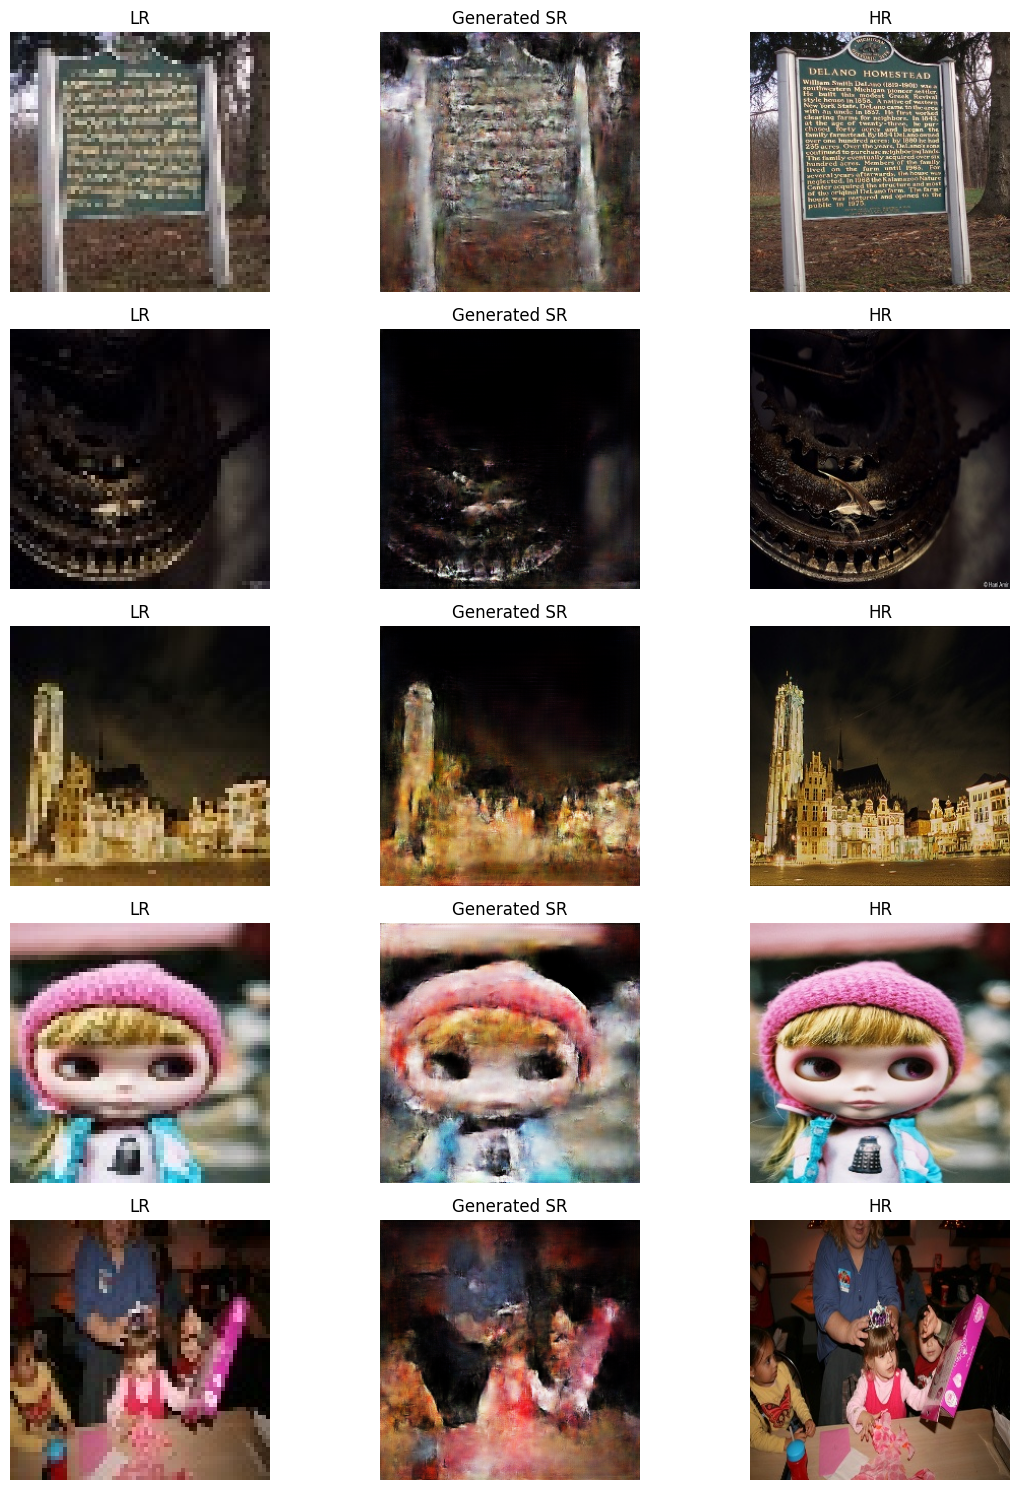

In [36]:
import matplotlib.pyplot as plt

# Generate SR images
generated_images = generator.predict(lr_test)

# Select a few random samples
num_samples = 5
sample_indices = np.random.choice(len(generated_images), num_samples, replace=False)

# Display LR, SR, and HR images
fig, axes = plt.subplots(num_samples, 3, figsize=(12, 15))
for i, idx in enumerate(sample_indices):
    lr_image = lr_test[idx]
    sr_image = generated_images[idx]
    hr_image = hr_test[idx]

    axes[i, 0].imshow(lr_image)
    axes[i, 0].set_title("LR")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(sr_image*0.5 + 0.5)
    axes[i, 1].set_title("Generated SR")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(hr_image*0.5 + 0.5)
    axes[i, 2].set_title("HR")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
### Model should be trained for much more many epochs in order to produce good results!!
### The purpose of this notebook is to get a glimpse of the SRGAN model